In [1]:
import yaml
import json
from pathlib import Path
import pandas as pd
import torch

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/cifar10/logs/decomposed")

In [2]:
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")

number of folders: 120


In [3]:
from datetime import datetime

dts = [datetime.fromtimestamp(int(x)) for x in folders]
print(max(dts))
print(min(dts))

2022-03-08 05:44:30
2022-03-07 19:11:43


In [4]:
paths = []
for folder in folders:
    found_decomp = False
    found_results = False
    for subfolder in os.listdir(logdir / folder):
        if 'lr' in subfolder:
            # found_decomp = True
            # break
            if (logdir / folder / subfolder / "results.json").exists():
                paths.append( logdir / folder / subfolder )
    # if not found_decomp or not found_results:
    #     folders.remove(folder)
print(len(paths))

120


In [6]:
# baseline

baseline_path = Path("/bigdata/cifar10/logs/baselines/1646668631/rn18_18_dNone_128_adam_l0.001_g0.1_w0.0_sTrue")
baseline_model = torch.load(baseline_path / "cnn_best.pth")

In [7]:
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)

In [8]:
baseline_result

{'best_epoch': 229,
 'best_train_acc': 0.9999333333333333,
 'best_valid_acc': 0.9216,
 'best_valid_loss': 0.005079200401902199,
 'test_acc': 0.9137,
 'test_loss': 0.005285387974977494,
 'n_param': 11173962,
 'model_name': 'rn18_18_dNone_128_adam_l0.001_g0.1_w0.0_sTrue'}

In [9]:
def paths_to_results(paths):
    """Returns a pandas DataFrame with results"""
    results = []
    for path in paths:
        with open(path/'results.json') as json_file:
            result = json.load(json_file)
        results.append(result)
    
    keys = set()
    for result in results:
        keys = keys.union( set(result.keys()) )
    
    blank = {k:[] for k in keys}
    
    df = pd.DataFrame(blank) #.append(results[1], ignore_index=True)

    for result in results:
        df = df.append(result, ignore_index=True)
        
    df['compression'] = df['n_param_fact']/df['n_param'][0]
    df.compression[0] = 1.0
    
    
    return df

In [10]:
import torch
import tensorly as tl
tl.set_backend('pytorch')
from tddl.factorizations import number_layers
from tddl.factorizations import listify_numbered_layers

def relative_error(pre_weight, dec_weight):
    with torch.no_grad():
        return tl.norm(pre_weight-dec_weight)/tl.norm(pre_weight)

def process_factorized_network(model, fact_model, layer_nrs, first_layer_nr=0):

    pretrained_numbered_layers = number_layers(model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers, 
        layer_nrs=layer_nrs
    )

    decomposed_numbered_layers_resnet18 = number_layers(fact_model)
    decomposed_conv_layers_resnet18 = listify_numbered_layers(
        decomposed_numbered_layers_resnet18, 
        layer_nrs=layer_nrs
    )

    errors_conv_resnet18 = {
        'name': [],
        'nr': [],
        'error': [],
    }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers_resnet18):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        print(name)
        nr = pre[1]
        print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        
        errors_conv_resnet18['name'].append(name)
        errors_conv_resnet18['nr'].append(nr)
        errors_conv_resnet18['error'].append(float(error))

    df_errors = pd.DataFrame(data=errors_conv_resnet18)
    if first_layer_nr is not None:
        df_errors.name.iloc[first_layer_nr] = 'in'
    df_errors.set_index('nr', inplace=True)
    grouped_errors = df_errors.groupby(by='name')
    grouped_errors['error'].plot(legend=True, style=".-", ylabel='Relative Error', xlabel='Layer Number')

/home/jetzeschuurman/gitProjects/phd/tltorch/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [11]:
# calc approximation error
# store in approx_error.json, next to results.json
import yaml

for path in paths:
    print(path)
    timestamp = Path(path).parent
    config_path = logdir / timestamp / "config.yml"
    config_data = yaml.load(config_path.read_text(), Loader=yaml.Loader)
    layers = config_data['layers']

    fact_model = torch.load(path / 'model_after_fact.pth')

    pretrained_numbered_layers = number_layers(baseline_model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers,
        layer_nrs=layers,
    )

    decomposed_numbered_layers = number_layers(fact_model)
    decomposed_conv_layers = listify_numbered_layers(
        decomposed_numbered_layers,
        layer_nrs=layers,
    )

    with open(path / 'results.json') as json_file:
        result = json.load(json_file)

    with open(path / 'results_before_training.json') as json_file:
        result_before_training = json.load(json_file)

    errors_conv = {
            'name': [],
            'nr': [],
            'error': [],
            'layers': layers,
            'factorization': config_data['factorization'],
            'rank': config_data['rank'],
            'valid_acc': result['best_valid_acc'],
            'valid_acc_before_ft': result_before_training['valid_acc'],
            'n_param_fact': result['n_param_fact'],
            'test_acc': result['test_acc'],
            'lr': config_data['lr'],
            'optimizer': config_data['optimizer'],
        }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        # print(name)
        nr = pre[1]
        # print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        # print(error)
        
        errors_conv['name'].append(name)
        errors_conv['nr'].append(nr)
        errors_conv['error'].append(float(error))

    errors_path = logdir / path / 'results_approximation_error.json'
    with open(errors_path, 'w') as f:
        json.dump(errors_conv, f)

/bigdata/cifar10/logs/decomposed/1646683474/rn18-lr-[28]-tucker-0.1-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1646682219/rn18-lr-[28]-tucker-0.9-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1646684848/rn18-lr-[63]-tucker-0.5-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1646682858/rn18-lr-[28]-cp-0.1-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1646709928/rn18-lr-[15]-cp-0.5-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1646696674/rn18-lr-[38]-cp-0.5-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1646703084/rn18-lr-[28]-tucker-0.25-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1646705496/rn18-lr-[28]-tucker-0.75-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1646702994/rn18-lr-[15]-cp-0.5-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/

In [12]:
results = []
for path in paths:
    with open(path / 'results_approximation_error.json') as json_file:
        result = json.load(json_file)
    # print(result)
    for k,v in result.items():
        result[k] = v[0] if type(v) == list else v
    results.append(result)

In [13]:
df = pd.DataFrame(results)
df.head()


,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer
0,conv1,28,0.823151,28,tucker,0.1,0.9018,0.8690,11041517,0.8974,0.00001,adam
1,conv1,28,0.305965,28,tucker,0.90,0.9182,0.9156,11159148,0.9145,0.00001,adam
2,conv2,63,0.198279,63,tucker,0.5,0.9210,0.9216,9997024,0.9145,0.00001,adam
3,conv1,28,0.782636,28,cp,0.1,0.9094,0.8890,11041234,0.9048,0.00001,adam
4,conv2,15,0.304725,15,cp,0.5,0.9206,0.9198,11155728,0.9140,0.00001,adam


In [14]:
df['rank'] = df['rank'].astype(float, copy=False)
# df['rank'].apply(float)
df['rank'].unique()
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df['fact_layers'] = df['factorization'] + '-' + df['layers'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,fact_rank,fact_layers
0,conv1,28,0.823151,28,tucker,0.1,0.9018,0.8690,11041517,0.8974,0.00001,adam,tucker-0.1,tucker-28
1,conv1,28,0.305965,28,tucker,0.9,0.9182,0.9156,11159148,0.9145,0.00001,adam,tucker-0.9,tucker-28
2,conv2,63,0.198279,63,tucker,0.5,0.9210,0.9216,9997024,0.9145,0.00001,adam,tucker-0.5,tucker-63
3,conv1,28,0.782636,28,cp,0.1,0.9094,0.8890,11041234,0.9048,0.00001,adam,cp-0.1,cp-28
4,conv2,15,0.304725,15,cp,0.5,0.9206,0.9198,11155728,0.9140,0.00001,adam,cp-0.5,cp-15


In [15]:
df_rank = df.set_index('rank', inplace=False)

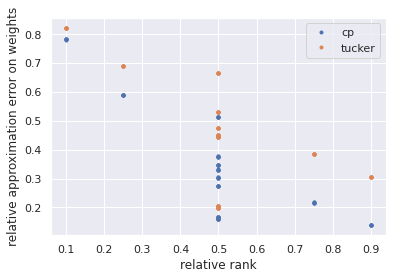

In [16]:
grouped_df = df_rank.groupby('factorization')
ax = grouped_df['error'].plot(legend=True, style=".", ylabel='relative approximation error on weights', xlabel='relative rank')

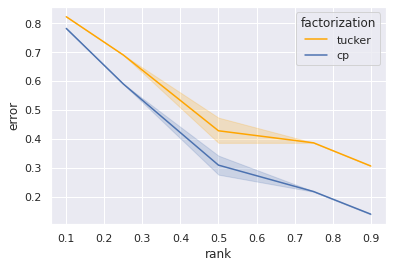

In [17]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)
# Plot the responses for different events and regions
ax = sns.lineplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)

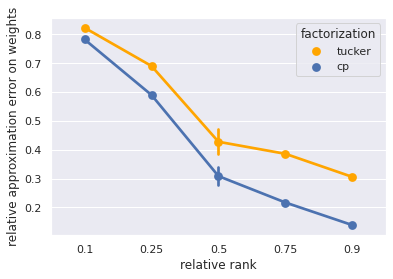

In [63]:
ax = sns.pointplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.set(xlabel='relative rank', ylabel='relative approximation error on weights')

[(0.865, 0.925)]

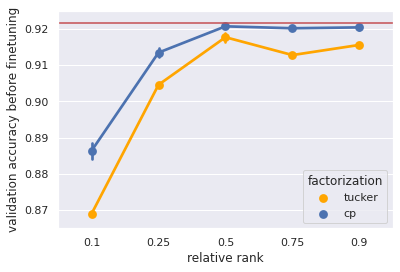

In [19]:
ax = sns.pointplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative rank', ylabel='validation accuracy before finetuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

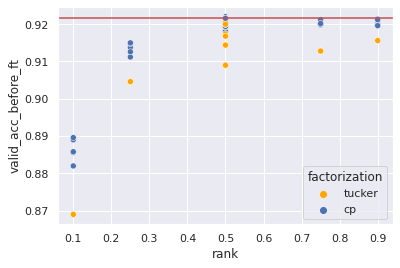

In [20]:
ax = sns.scatterplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['best_valid_acc'], color='r')

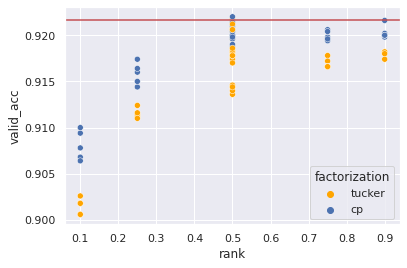

In [21]:
ax = sns.scatterplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['best_valid_acc'], color='r')

[(0.865, 0.925)]

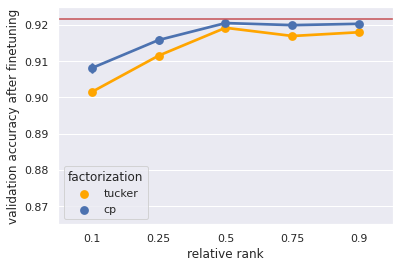

In [22]:
ax = sns.pointplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='relative rank', ylabel='validation accuracy after finetuning')
ax.set(ylim=(0.865, 0.925))

[Text(0.5, 0, 'relative rank'), Text(0, 0.5, 'test accuracy after finetuning')]

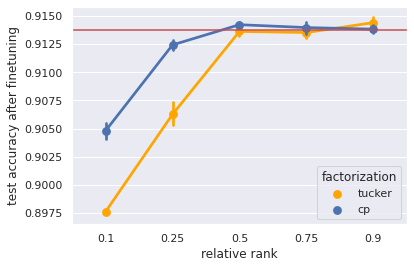

In [23]:
ax = sns.pointplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='relative rank', ylabel='test accuracy after finetuning')
# ax.set(ylim=(0.865, 0.925))

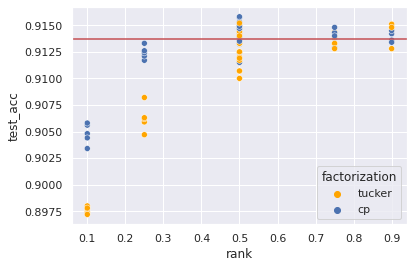

In [24]:
ax = sns.scatterplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['test_acc'], color='r')

In [25]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['rank'].plot(legend=True, style=".-", ylabel='relative rank', xlabel='relative approximation error')

In [26]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

[(0.865, 0.925)]

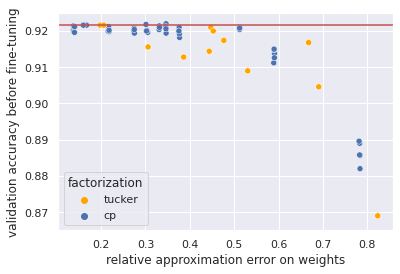

In [41]:
ax = sns.scatterplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df,
               palette=['orange', 'b'], 
               )
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy before fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

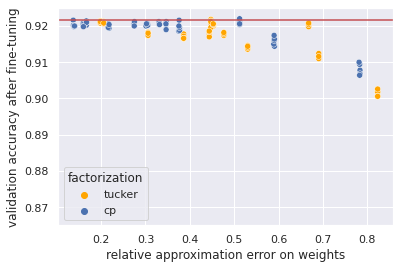

In [40]:
ax = sns.scatterplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

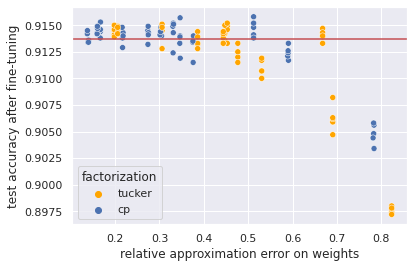

In [39]:
ax = sns.scatterplot(x="error", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on weights', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

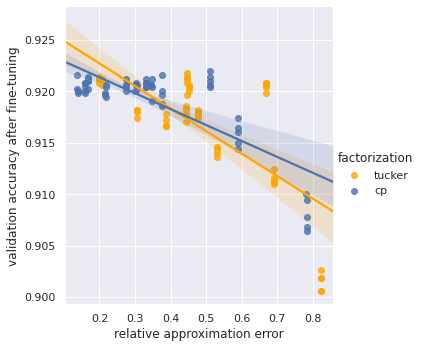

In [25]:
g = sns.lmplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    # y_jitter=.02, 
    # logistic=True, 
    # style="rank",
    truncate=False, palette=['orange', 'b'], 
)
g = g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')


In [26]:
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,fact_rank,fact_layers
0,conv1,28,0.823151,28,tucker,0.1,0.9018,0.8690,11041517,0.8974,0.00001,adam,tucker-0.1,tucker-28
1,conv1,28,0.305965,28,tucker,0.9,0.9182,0.9156,11159148,0.9145,0.00001,adam,tucker-0.9,tucker-28
2,conv2,63,0.198279,63,tucker,0.5,0.9210,0.9216,9997024,0.9145,0.00001,adam,tucker-0.5,tucker-63
3,conv1,28,0.782636,28,cp,0.1,0.9094,0.8890,11041234,0.9048,0.00001,adam,cp-0.1,cp-28
4,conv2,15,0.304725,15,cp,0.5,0.9206,0.9198,11155728,0.9140,0.00001,adam,cp-0.5,cp-15


In [27]:
# g = sns.lmplot(x="error", y="test_acc", 
#    hue="fact_rank", 
#    data=df,
#    truncate=False, 
#    # palette=['orange','b'],
# )
# g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')
# g.set(ylim=(0.935, 0.945))

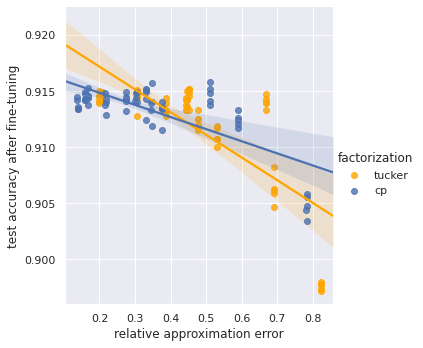

In [28]:
ax = sns.lmplot(x="error", y="test_acc", 
   hue="factorization", 
   data=df,
   # logistic=True,
   truncate=False, 
   palette=['orange','b'],
)
ax.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')


In [29]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

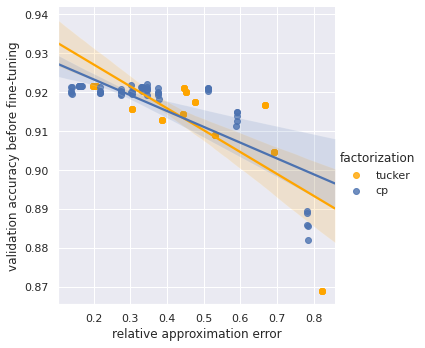

In [30]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

In [44]:
df_layers = pd.DataFrame(results)
df_layers['rank'] = df_layers['rank'].astype(float, copy=False)
df_layers = df_layers.loc[df_layers['rank'] == 0.5]
df_layers

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer
2,conv2,63,0.198279,63,tucker,0.5,0.9210,0.9216,9997024,0.9145,0.00001,adam
4,conv2,15,0.304725,15,cp,0.5,0.9206,0.9198,11155728,0.9140,0.00001,adam
5,conv2,38,0.346829,38,cp,0.5,0.9212,0.9208,10879449,0.9119,0.00001,adam
8,conv2,15,0.301261,15,cp,0.5,0.9200,0.9218,11155728,0.9141,0.00001,adam
9,conv1,28,0.375088,28,cp,0.5,0.9186,0.9198,11100409,0.9134,0.00001,adam
...,...,...,...,...,...,...,...,...,...,...,...,...
115,conv2,63,0.160493,63,cp,0.5,0.9200,0.9216,9995161,0.9147,0.00001,adam
116,conv1,60,0.167152,60,cp,0.5,0.9210,0.9216,9995161,0.9153,0.00001,adam
117,conv1,44,0.447319,44,tucker,0.5,0.9212,0.9210,10879741,0.9150,0.00001,adam
118,conv2,63,0.160246,63,cp,0.5,0.9198,0.9216,9995161,0.9149,0.00001,adam


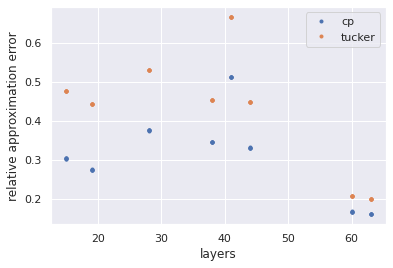

In [45]:
df_layers_idx = df_layers.set_index('layers', inplace=False)
grouped_df_layers = df_layers_idx.groupby('factorization')
ax = grouped_df_layers['error'].plot(legend=True, style=".", ylabel='relative approximation error')

In [46]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('layers', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['error'].plot(legend=True, style=".-", ylabel='relative approximation error')

# ax = grouped_df_layers['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

In [47]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('error', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

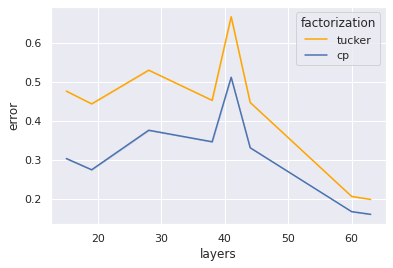

In [48]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)

# Plot the responses for different events and regions
ax = sns.lineplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             )

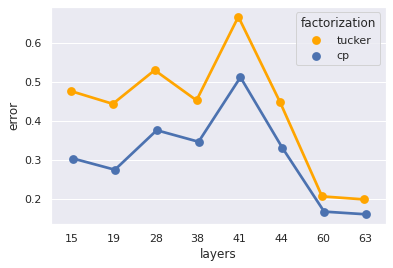

In [49]:
ax = sns.pointplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True
             )

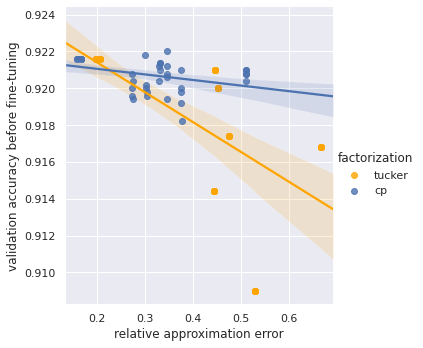

In [50]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

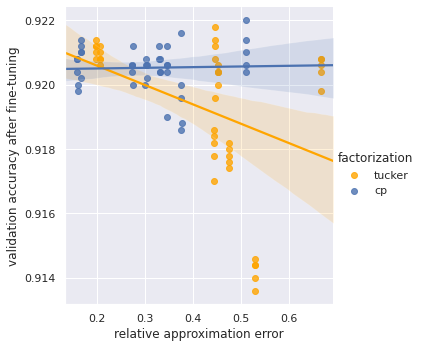

In [51]:
g = sns.lmplot(x="error", y="valid_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')

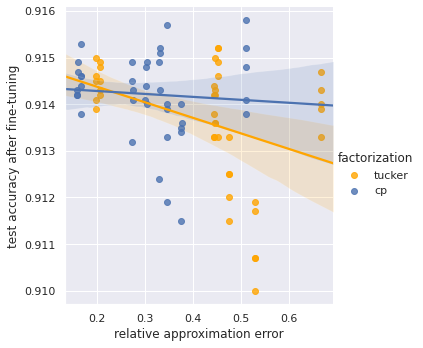

In [52]:
g = sns.lmplot(x="error", y="test_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')

[(0.908, 0.922)]

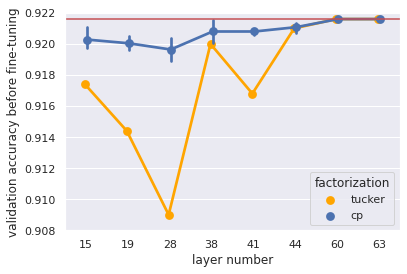

In [60]:
ax = sns.pointplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')
ax.set(ylim=(0.908, 0.9220))

[(0.908, 0.922)]

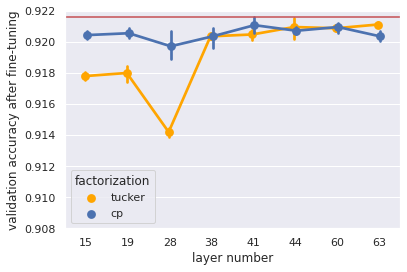

In [62]:
ax = sns.pointplot(x="layers", y="valid_acc",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy after fine-tuning')
ax.set(ylim=(0.908, 0.9220))


[Text(0.5, 0, 'layer number'), Text(0, 0.5, 'test accuracy after fine-tuning')]

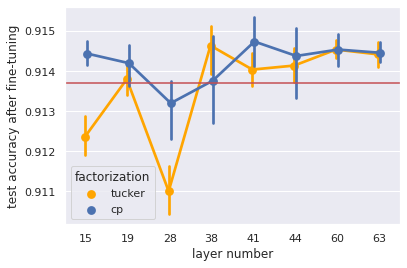

In [56]:
ax = sns.pointplot(x="layers", y="test_acc",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='layer number', ylabel='test accuracy after fine-tuning')

In [42]:
df.factorization.isna()

0      False
1      False
2      False
3      False
4      False
       ...  
115    False
116    False
117    False
118    False
119    False
Name: factorization, Length: 120, dtype: bool

In [43]:
df[df.error.isnull()]

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,fact_rank,fact_layers


In [44]:
df_layer_rank = df.groupby(['factorization','layers','rank'])
df_std = df_layer_rank[['valid_acc','test_acc']].std()

print(df_std.to_latex())

# df.to_json("/home/jetzeschuurman/gitProjects/phd/tddl/artifacts/f_mnist/std_adam.json")

\begin{tabular}{lllrr}
\toprule
       &    &      &  valid\_acc &  test\_acc \\
factorization & layers & rank &            &           \\
\midrule
cp & 15 & 0.50 &   0.000329 &  0.000404 \\
       & 19 & 0.50 &   0.000434 &  0.000632 \\
       & 28 & 0.10 &   0.001579 &  0.000970 \\
       &    & 0.25 &   0.001178 &  0.000597 \\
       &    & 0.50 &   0.001197 &  0.000977 \\
       &    & 0.75 &   0.000518 &  0.000702 \\
       &    & 0.90 &   0.000729 &  0.000502 \\
       & 38 & 0.50 &   0.000817 &  0.001370 \\
       & 41 & 0.50 &   0.000642 &  0.000811 \\
       & 44 & 0.50 &   0.000335 &  0.001161 \\
       & 60 & 0.50 &   0.000456 &  0.000537 \\
       & 63 & 0.50 &   0.000456 &  0.000321 \\
tucker & 15 & 0.50 &   0.000316 &  0.000669 \\
       & 19 & 0.50 &   0.000632 &  0.000505 \\
       & 28 & 0.10 &   0.000867 &  0.000319 \\
       &    & 0.25 &   0.000540 &  0.001258 \\
       &    & 0.50 &   0.000400 &  0.000787 \\
       &    & 0.75 &   0.000537 &  0.000630 \\
       &  

## Analysis on the features space

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

In [ ]:
baseline_path = Path("/bigdata/cifar10/logs/baselines/1646668631/rn18_18_dNone_128_adam_l0.001_g0.1_w0.0_sTrue")
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)

In [ ]:
import os
import json

import pandas as pd

features_dict = {}
# for path in paths: #TODO: loop over dirs in folder
for 
    norms = []

    # go to folder with .json files
    feature_path = path / "features"
    # loop over files
    for filename in os.listdir(feature_path):
        with open(feature_path / filename) as json_file:
            data = json.load(json_file)
            norms.append(data)
 
    df = pd.DataFrame(norms)

    features_dict[path] = df
# iterate over files in
# that directory
# for filename in os.listdir(directory):
#     f = os.path.join(directory, filename)
#     # checking if it is a file
#     if os.path.isfile(f):
#         print(f)

    


    # calculate mean, meadian, std

    # save with settings and other results

